In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

%matplotlib inline

In [2]:
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

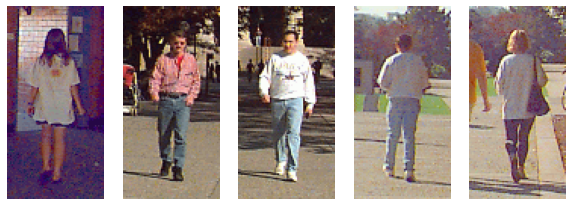

In [9]:
# load_images_from_folder('pedestrians128x64')

extractdir='C:/Users/Dishaa/Prashant Sir -DataScience/Open-CV/pedestrians128x64'
plt.figure(figsize=(10, 6))
for i in range(5):
    filename = "%s/per0010%d.ppm" % (extractdir, i)
    img = cv2.imread(filename) ## read the image
#     print(img.shape) ### (128, 64, 3)

    plt.subplot(1, 5, i + 1) ## create subplots
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) ## converting the image to RBG
    plt.axis('off')

### HOG( Histogram for Oriented Gradients)

**Feature Descriptor** : It provides a simplified version of image which contains the most important information abt the image.

- HOG is a Feature Descriptor which is generally used for the purpose of Feature Engineering.
- Generally used in object detection and computer vision.
- In HOG, the whole image is broken down into ***patches*** or ***regions*** and then for each region the gradients and orientation are calculated.
- Finally the HOG would generate a ***Histogram*** for each of these regions separately. Then, the descriptor is assembled by concatenating the different histograms. 

In [4]:
win_size=(48, 96) ## As we want only the Center image whicg has person
block_size=(16,16)
block_stride=(8,8)
cell_size=(8,8)
num_bins=9

hog=cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

In [44]:
hog

<HOGDescriptor 00000161BBB53F50>

Now we will create a sample=**X_pos** for all the pesdestrial images

In [5]:
X_pos=[]
random.seed(42)

for i in random.sample(range(900),400):
    filename = "%s/per%05d.ppm" % (extractdir, i)
    img = cv2.imread(filename)
    if img is None:
        print('Could not find image %s' % filename)
        continue
    X_pos.append(hog.compute(img, (64, 64)))

Could not find image C:/Users/Dishaa/Prashant Sir -DataScience/Open-CV/pedestrians128x64/per00000.ppm


##### We should also remember that OpenCV wants the feature matrix to contain 32-bit floating point numbers, and the target labels to be 32-bit integers. 

In [6]:
X_pos = np.array(X_pos, dtype=np.float32)
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)
X_pos.shape, y_pos.shape

((399, 1980, 1), (399,))

Now we will create a sample =**X_neg** which will have everything except Pedestrial.

In [7]:
negset = "pedestrians_neg"
negfile = "%s/%s.tar.gz" % ('C:/Users/Dishaa/Prashant Sir -DataScience/Open-CV', 'pedestrians_neg')
negdir = "%s/%s" % ('C:/Users/Dishaa/Prashant Sir -DataScience/Open-CV', 'pedestrians_neg')
# extract_tar(negfile, datadir)

In [19]:
wroi=64 ## no of col
hroi=128 ## no of rows
X_neg=[]
for negfile in os.listdir(negdir):
    filename = '%s/%s' % (negdir, negfile)
    img = cv2.imread(filename)
    img=cv2.resize(img,(512,512))
    for j in range(5):
        rand_x=random.randint(0,img.shape[1]-wroi)
        rand_y=random.randint(0,img.shape[0]-hroi)
        roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]
    X_neg.append(hog.compute(roi, (64, 64)))

In [20]:
X_neg = np.array(X_neg, dtype=np.float32)
y_neg = -np.ones(X_neg.shape[0], dtype=np.int32) ## Corresponding to the negative class
X_neg.shape, y_neg.shape

((50, 1980, 1), (50,))

In [21]:
## Concatinating the X & y

X = np.concatenate((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
## SVM model

svm=cv2.ml.SVM_create()
svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)

True

In [24]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

def acc_score(X,Y):
    _, y_pred = svm.predict(X)
    return accuracy_score(Y,y_pred)

In [25]:
acc_score(X_train,y_train)

1.0

In [26]:
acc_score(X_test,y_test)

0.8666666666666667

Since we can see that our test score < train score which is a clear sign of overfitting.

In [77]:
_, y_pred = svm.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

## Note: -1=-ve class acc to Confusion Matrix

[[12  0]
 [ 0 78]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        78

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



We can see that Our model is facing a hard time predicting Negative class

We can clearly see from the Confusion Matrix that we are getting **FP(False Positive)** which means that our model is predicting neg images which are auctually Pedestrial images. 

Therefore we will be using **BOOTSTRAPPING METHOD** to improve the performance of our model.




#### BOOTSTRAPPING

In this method we detect the FP from the test and add those to the train dataset. In this way we we can train our model to classify the FP images also.

In [84]:

score_train = []
score_test = []
for j in range(5):
    svm=cv2.ml.SVM_create()
    svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
    score_train.append(acc_score(X_train,y_train))
    score_test.append(acc_score(X_test,y_test))
    
    _, y_pred = svm.predict(X_test)
    false_pos = np.logical_and((y_test.ravel() == -1), (y_pred.ravel() == 1))  ##ravel()>> flattens the array
    if not np.any(false_pos):
        print('done')
        break
    X_train = np.concatenate((X_train, X_test[false_pos, :]), axis=0)
    y_train = np.concatenate((y_train, y_test[false_pos]), axis=0)

In [83]:
score_train

[1.0]

In [79]:
acc_score(X_train,y_train)

1.0

In [80]:
acc_score(X_test,y_test)

1.0

In [81]:
svm=cv2.ml.SVM_create()
svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)

True

In [82]:
_, y_pred = svm.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[12  0]
 [ 0 78]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        78

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



###### We can clearly see that our accuracy has improved alot and our model is able to predict the minority class as well

OpenCV provides a defauld method for Detection of ppl.So we will be using that to test our model on the test image.

In [46]:
hogdef = cv2.HOGDescriptor()
hogdef.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector()) ## Default method

Because pedestrians could appear not just at various locations but also in various sizes, we would have to rescale the image and repeat the whole process. Thankfully, OpenCV has a convenience function for this **multi-scale detection** task in the form of the detectMultiScale function. 

In [48]:
img_test=cv2.imread('C:/Users/Dishaa/Prashant Sir -DataScience/Open-CV/pedestrian_test.jpg')
found, _ = hogdef.detectMultiScale(img_test)  ## Returns feature matrix

In [57]:
found

array([[ 13, 111,  71, 142],
       [ 62, 111,  69, 138],
       [141,  95,  65, 130]], dtype=int32)

In [60]:
found[1]

array([ 62, 111,  69, 138], dtype=int32)

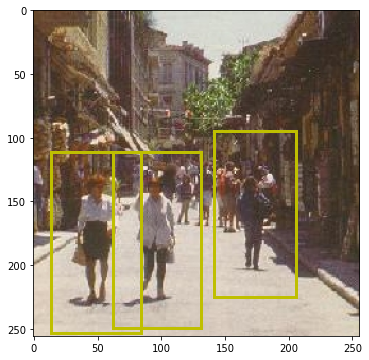

In [76]:
## https://www.geeksforgeeks.org/matplotlib-patches-rectangle-in-python/

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
from matplotlib import patches
for f in found:
    ax.add_patch(patches.Rectangle((f[0], f[1]), f[2], f[3], color='y', linewidth=3, fill=False))